In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import pickle
from tqdm import trange, tqdm
import numpy as np
import tikzplotlib
import matplotlib.pyplot as plt
import shap
shap.initjs()
from utills import chunker

import warnings
warnings.filterwarnings("ignore")

In [4]:
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [5]:
DATA_DIR = '../data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
DATA_PATH = DATA_DIR + 'pan20-authorship-verification-training-large.jsonl'
PREPROCESSED_DATA_PATH = '../temp_data/pan/'
# TEMP_DATA_PATH = '../temp_data/pan/'
FIGURES_PATH = '../figures/'

In [6]:
with open(PREPROCESSED_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (
        aucs,
        clf,
        roc_auc,
        transformer, 
        scaler,
        secondary_scaler,
        feature_sz,
        train_sz,
        train_idxs,
        test_sz,
        test_idxs
    ) = pickle.load(f)

In [7]:
fnames = np.array(transformer.get_feature_names())

In [8]:
XX_train = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_train.npy', dtype='float32', mode='r', shape=(train_sz, feature_sz))
XX_test = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_test.npy', dtype='float32', mode='r', shape=(test_sz, feature_sz))


In [9]:
XX_train_sampled = XX_train[np.random.choice(train_sz, 5000), :]
XX_test_sampled = XX_test[np.random.choice(test_sz, 5000), :]

In [10]:
explainer = shap.LinearExplainer(clf, XX_train_sampled)
shap_values = explainer.shap_values(XX_test_sampled)

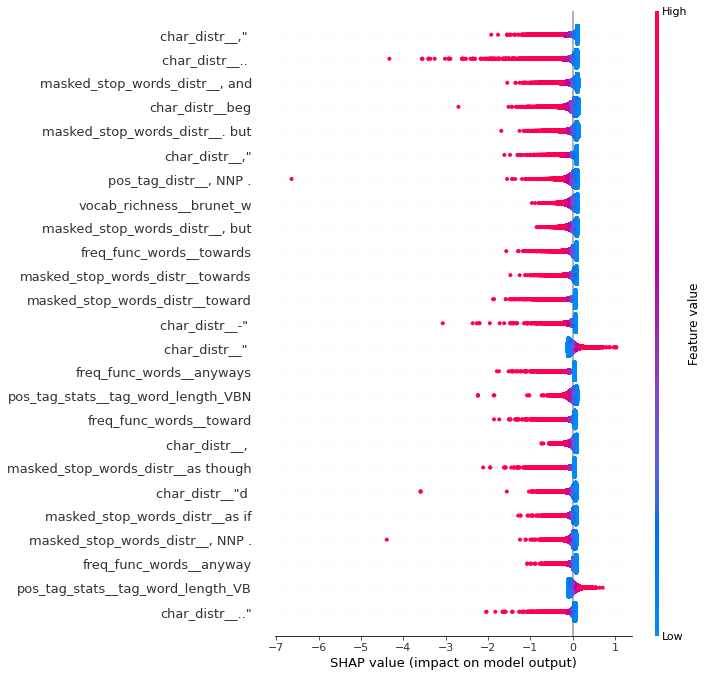

In [21]:
plt.clf()
shap.summary_plot(shap_values, XX_test_sampled, feature_names=transformer.get_feature_names(), max_display=25)
plt.tight_layout()

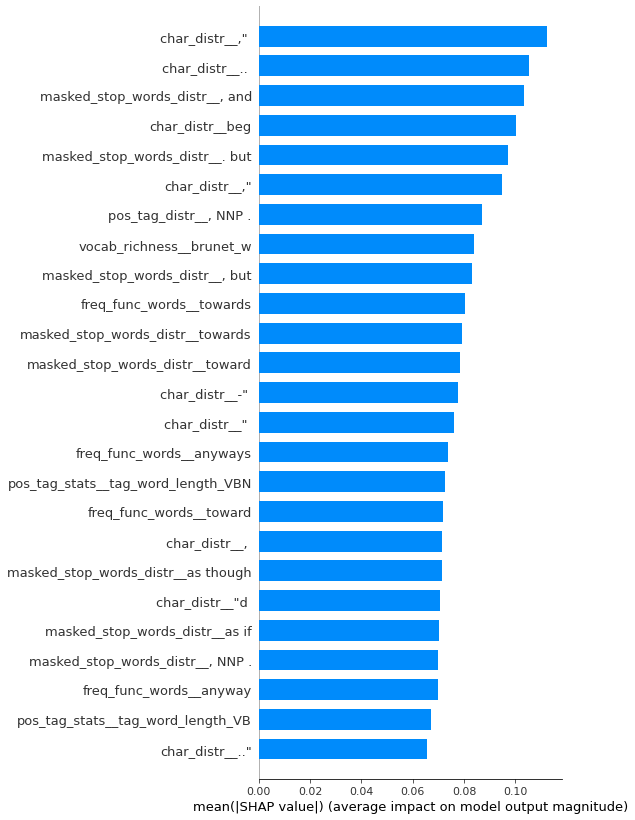

In [23]:
plt.clf()
shap.summary_plot(shap_values, XX_test_sampled, feature_names=transformer.get_feature_names(), max_display=25, plot_type="bar")
plt.tight_layout()

In [11]:
shap_means = np.abs(shap_values).mean(axis=0)

In [44]:
order = np.argsort(-np.abs(shap_means))
for i in range(25):
    print('{:.3f}'.format(round(shap_means[order[i]], 3)), fnames[order[i]])

0.112 [char_distr__," ]
0.105 [char_distr__.. ]
0.103 [masked_stop_words_distr__, and]
0.100 [char_distr__beg]
0.097 [masked_stop_words_distr__. but]
0.095 [char_distr__,"]
0.087 [pos_tag_distr__, NNP .]
0.084 [vocab_richness__brunet_w]
0.083 [masked_stop_words_distr__, but]
0.080 [freq_func_words__towards]
0.079 [masked_stop_words_distr__towards]
0.079 [masked_stop_words_distr__toward]
0.078 [char_distr__-" ]
0.076 [char_distr__" ]
0.074 [freq_func_words__anyways]
0.073 [pos_tag_stats__tag_word_length_VBN]
0.072 [freq_func_words__toward]
0.072 [char_distr__, ]
0.071 [masked_stop_words_distr__as though]
0.071 [char_distr__"d ]
0.070 [masked_stop_words_distr__as if]
0.070 [masked_stop_words_distr__, NNP .]
0.070 [freq_func_words__anyway]
0.067 [pos_tag_stats__tag_word_length_VB]
0.066 [char_distr__.."]


In [42]:
featureset_bounds = {}
i = 0
for k, t in transformer.transformer_list:
    featureset_bounds[k] = (i, i + len(t.get_feature_names()))
    i += len(t.get_feature_names())
    
featuresets = np.array(list(featureset_bounds.keys()))
featureset_shap_means = np.array([shap_means[featureset_bounds[k][0]:featureset_bounds[k][1]].mean() for k in featuresets])

fig = go.Figure()
for i in np.argsort(-featureset_shap_means):
    k = featuresets[i]
    fig.add_trace(go.Violin(
        x = shap_means[featureset_bounds[k][0]:featureset_bounds[k][1]],
        text = fnames[featureset_bounds[k][0]:featureset_bounds[k][1]],
        name = k
    ))
fig.show()

In [12]:
order = np.argsort(-np.abs(shap_means))
for i in range(25):
    print('{:.3f}'.format(round(shap_means[order[i]], 3)), fnames[order[i]])

0.109 char_distr__," 
0.107 masked_stop_words_distr__, and
0.104 char_distr__.. 
0.100 char_distr__beg
0.100 masked_stop_words_distr__. but
0.092 char_distr__,"
0.088 pos_tag_distr__, NNP .
0.083 vocab_richness__brunet_w
0.083 masked_stop_words_distr__, but
0.080 freq_func_words__towards
0.080 masked_stop_words_distr__toward
0.080 masked_stop_words_distr__towards
0.077 freq_func_words__anyways
0.076 char_distr__-" 
0.074 char_distr__" 
0.073 freq_func_words__toward
0.072 pos_tag_stats__tag_word_length_VBN
0.072 char_distr__, 
0.071 masked_stop_words_distr__, NNP .
0.070 masked_stop_words_distr__as though
0.069 masked_stop_words_distr__as if
0.069 freq_func_words__anyway
0.069 char_distr__"d 
0.067 pos_tag_stats__tag_word_length_VB
0.066 char_distr__.."


In [18]:
XX_test_sampled[:, [order[3]]]

(5000, 1)